In [2]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import pymoc
import glob
from time import sleep
import os
from astropy.nddata.utils import Cutout2D
from astropy.convolution import Gaussian2DKernel
#import herschelhelp.cutouts_server as ctts
import scipy

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
#from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp import image_plotting,utils
import pyvo as vo
import glob

import copy
from scipy.signal import convolve2d

In [3]:
def fit_2d_gaus(model_image,sig_maj,sig_min,source_flux):
    
    n_size = 81

    prf = Gaussian2DKernel(sig_maj,sig_min,x_size=n_size,y_size=n_size)
    prf.normalize(mode='peak')
    prf = prf.array
    
    size = int(np.sqrt(model_image.shape))
    model_image = model_image.reshape([size,size])
    model_image = model_image*source_flux

    convolvedimg = convolve2d(model_image,prf,mode='same')
    
    return(convolvedimg.flatten())

In [4]:
def fit_source_flux(model_image,source_flux):
    
    n_size = 81

    sig_maj = 6/2.355
    sig_min = 6/2.355
    prf = Gaussian2DKernel(sig_maj,sig_min,x_size=n_size,y_size=n_size)
    prf.normalize(mode='peak')
    prf = prf.array
    
    size = int(np.sqrt(model_image.shape))
    model_image = model_image.reshape([size,size])
    model_image = model_image*source_flux

    convolvedimg = convolve2d(model_image,prf,mode='same')
    
    return(convolvedimg.flatten())

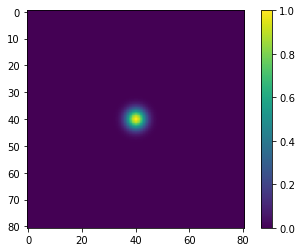

In [5]:
#generate a psf for the first object in the catalogue 
n = 1
n_size = 81

sig_maj = 6/2.355
sig_min = 6/2.355


prf = Gaussian2DKernel(sig_maj,sig_min,x_size=n_size,y_size=n_size)
prf.normalize(mode='peak')

plt.imshow(prf.array)
plt.colorbar()
plt.show()




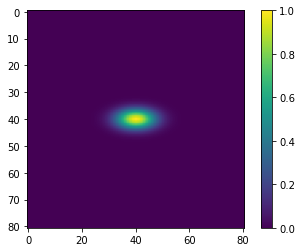

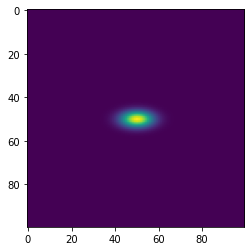

In [6]:
#generate a psf for the first object in the catalogue 
n = 1
n_size = 81

sig_maj = 12/2.355
sig_min = 6/2.355


prf = Gaussian2DKernel(sig_maj,sig_min,x_size=n_size,y_size=n_size)
prf.normalize(mode='peak')

plt.imshow(prf.array)
plt.colorbar()
plt.show()


model_image = np.zeros([100,100])
source_flux = 10
model_image[50,50] = 1
model_image = model_image*source_flux

convolvedimg = convolve2d(model_image,prf.array,mode='same')

plt.imshow(convolvedimg)
plt.show()

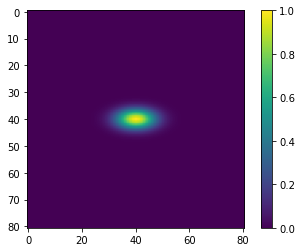

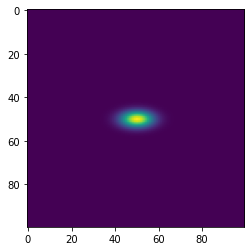

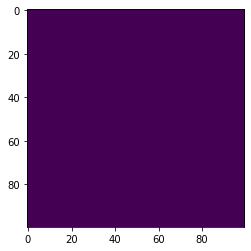

10.0
1.0


In [7]:
model_input = np.zeros([100,100])
model_input[50,50] = 1
popt,pcov = scipy.optimize.curve_fit(fit_2d_gaus,model_input.flatten(),convolvedimg.flatten())

n = 1
n_size = 81

sig_maj = popt[0]
sig_min = popt[1]


prf_measure = Gaussian2DKernel(sig_maj,sig_min,x_size=n_size,y_size=n_size)
prf_measure.normalize(mode='peak')

plt.imshow(prf_measure.array)
plt.colorbar()
plt.show()


model_image = np.zeros([100,100])
source_flux = popt[2]
model_image[50,50] = 1
model_image = model_image*source_flux

convolvedimg_measure = convolve2d(model_image,prf.array,mode='same')

plt.imshow(convolvedimg_measure)
plt.show()


plt.imshow(convolvedimg-convolvedimg_measure)
plt.show()
print(source_flux)
print(np.sum(convolvedimg) / np.sum(convolvedimg_measure))

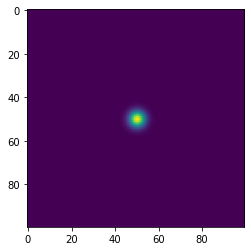

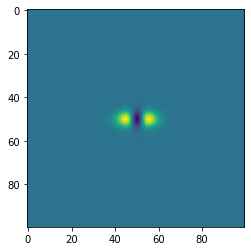

12.649110646065077
1.581138829410242


In [8]:
model_input = np.zeros([100,100])
model_input[50,50] = 1
popt,pcov = scipy.optimize.curve_fit(fit_source_flux,model_input.flatten(),convolvedimg.flatten())

n = 1
n_size = 81

sig_maj = 6/2.355
sig_min = 6/2.355


prf = Gaussian2DKernel(sig_maj,sig_min,x_size=n_size,y_size=n_size)
prf.normalize(mode='peak')


model_image = np.zeros([100,100])
source_flux = popt[0]
model_image[50,50] = 1
model_image = model_image*source_flux

convolvedimg_measure = convolve2d(model_image,prf.array,mode='same')

plt.imshow(convolvedimg_measure)
plt.show()


plt.imshow(convolvedimg-convolvedimg_measure)
plt.show()
print(source_flux)
print(np.sum(convolvedimg) / np.sum(convolvedimg_measure))

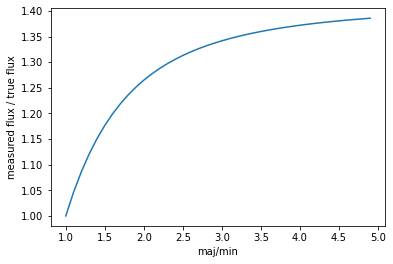

In [9]:
model_image = np.zeros([100,100])
source_flux = 10
model_image[50,50] = 1
model_image = model_image*source_flux

sig_ratio = np.arange(1,5,0.1)
source_fluxes = np.array([])
for n in range(len(sig_ratio)):
    n_size = 81

    sig_min = 6/2.355
    sig_maj = sig_min*sig_ratio[n]

    prf = Gaussian2DKernel(sig_maj,sig_min,x_size=n_size,y_size=n_size)
    prf.normalize(mode='peak')
    
    convolvedimg = convolve2d(model_image,prf.array,mode='same')
    
    popt,pcov = scipy.optimize.curve_fit(fit_source_flux,model_input.flatten(),convolvedimg.flatten())
    
    source_fluxes = np.append(source_fluxes,popt[0])
    
x = sig_ratio
y = source_fluxes/10
plt.plot(x,y)
plt.xlabel('maj/min')
plt.ylabel('measured flux / true flux')
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


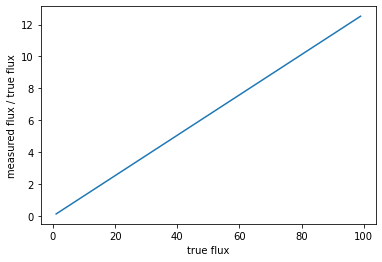

In [10]:
model_image = np.zeros([100,100])
source_flux = 10
model_image[50,50] = 1
model_image = model_image*source_flux

fluxes = np.arange(1,100,1)
source_fluxes = np.array([])
for n in range(len(fluxes)):
    print(n)
    model_image = np.zeros([100,100])
    source_flux = fluxes[n]
    model_image[50,50] = 1
    model_image = model_image*source_flux


    n_size = 81

    sig_min = 6/2.355
    sig_maj = sig_min*2

    prf = Gaussian2DKernel(sig_maj,sig_min,x_size=n_size,y_size=n_size)
    prf.normalize(mode='peak')
    
    convolvedimg = convolve2d(model_image,prf.array,mode='same')
    
    popt,pcov = scipy.optimize.curve_fit(fit_source_flux,model_input.flatten(),convolvedimg.flatten())
    
    source_fluxes = np.append(source_fluxes,popt[0])
    
x = fluxes
y = source_fluxes/10
plt.plot(x,y)
plt.xlabel('true flux')
plt.ylabel('measured flux / true flux')
plt.show()

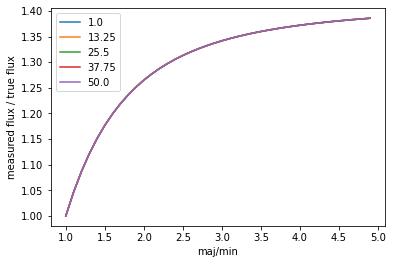

In [13]:
model_image = np.zeros([100,100])
source_flux = 10
model_image[50,50] = 1
model_image = model_image*source_flux

fluxes = np.linspace(1,50,5)
for n in range(len(fluxes)):
    
    model_image = np.zeros([100,100])
    source_flux = fluxes[n]
    model_image[50,50] = 1
    model_image = model_image*source_flux
    
    sig_ratio = np.arange(1,5,0.1)
    source_fluxes = np.array([])
    for m in range(len(sig_ratio)):
        n_size = 81

        sig_min = 6/2.355
        sig_maj = sig_min*sig_ratio[m]

        prf = Gaussian2DKernel(sig_maj,sig_min,x_size=n_size,y_size=n_size)
        prf.normalize(mode='peak')

        convolvedimg = convolve2d(model_image,prf.array,mode='same')

        popt,pcov = scipy.optimize.curve_fit(fit_source_flux,model_input.flatten(),convolvedimg.flatten())

        source_fluxes = np.append(source_fluxes,popt[0])

    x = sig_ratio
    y = source_fluxes/fluxes[n]
    plt.plot(x,y,label=fluxes[n])
plt.xlabel('maj/min')
plt.ylabel('measured flux / true flux')
plt.legend()
plt.show()